# Comparing efficiency metrics for model runoff calibration
Study comparing different metrics, [Comparison of different efficiency criteria for hydrological model
assessment (Krause et al. 2005)](https://adgeo.copernicus.org/articles/5/89/2005/adgeo-5-89-2005.pdf)

In [1]:
import __init__
import scripts.config as config
import numpy as np
import pandas as pd
import tempfile
import datetime
from sklearn.svm import SVR
import geopandas as gpd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from matplotlib.font_manager import FontProperties
import seaborn as sns
# import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib
import HydroErr as he

In [2]:
# Plotting parameters

XSMALL_SIZE = 6
SMALL_SIZE = 7
MEDIUM_SIZE = 9
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the figure title
plt.rcParams['figure.dpi'] = 140

In [3]:
# Import and format observed data (2003-2007 runoff)

input_dir = config.velma_data
results_dir = config.data_path.parents[0] / 'results' / 'calibration' / 'ellsworth_baseline_03_07_12'

runoff_path = input_dir / 'runoff' / 'ellsworth_Q_2003_2007_dummy.csv'
runoff_start = pd.to_datetime('01-01-2003')
runoff_end = pd.to_datetime('12-31-2007')
nse_start = pd.to_datetime('01-01-2004')
nse_end = pd.to_datetime('12-31-2007')

runoff_obs = pd.read_csv(runoff_path, names=['runoff_obs'])
runoff_obs.index = pd.date_range(runoff_start, runoff_end)
runoff_obs['doy'], runoff_obs['year'] = runoff_obs.index.dayofyear, runoff_obs.index.year
runoff_obs = runoff_obs[(runoff_obs.index >= nse_start) & (runoff_obs.index <= nse_end)]

flow_path = config.streamflow
quality = pd.read_csv(flow_path, usecols=['Date', 'Quality'], parse_dates=True, index_col=0)
quality = quality[(quality.index >= nse_start) & (quality.index <= nse_end)]

precip_path = input_dir / 'precip' / 'PRISM_gauge_avg_ppt_2003_2019.csv'
forcing_start = pd.to_datetime('01-01-2003')
forcing_end = pd.to_datetime('12-31-2019')                     
precip = pd.read_csv(precip_path, names=['precip'])
precip.index = pd.date_range(forcing_start, forcing_end)
precip['doy'], precip['year'] = precip.index.dayofyear, precip.index.year
precip = precip[(precip.index >= nse_start) & (precip.index <= nse_end)]

temp_path = input_dir / 'temp' / 'ellsworth_temp_2003_2019.csv'
temp = pd.read_csv(temp_path, names=['temp'])
temp.index = pd.date_range(forcing_start, forcing_end)
temp['doy'], temp['year'] = temp.index.dayofyear, temp.index.year
temp = temp[(temp.index >= nse_start) & (temp.index <= nse_end)]

# Import VELMA outputs
velma_results = pd.read_csv(results_dir / 'DailyResults.csv')

# Format datetime of results
jday_pad = velma_results['Day'].apply(lambda x: str(x).zfill(3))
str_year = velma_results['Year'].apply(lambda x: str(x))
velma_results['year_jday'] = str_year + jday_pad
velma_results.index = pd.to_datetime(velma_results['year_jday'], format='%Y%j')
velma_results = velma_results[(velma_results.index >= nse_start) & (velma_results.index <= nse_end)]

## Plotting

In [4]:
# Group measurements by year
runoff_sim_yearly = pd.pivot_table(velma_results, index=['Day'], columns=['Year'],
                                   values=['Runoff_All(mm/day)_Delineated_Average'])
runoff_obs_yearly = pd.pivot_table(runoff_obs, index=['doy'], columns=['year'], values=['runoff_obs'])
precip_yearly = pd.pivot_table(precip, index=['doy'], columns=['year'], values=['precip'])

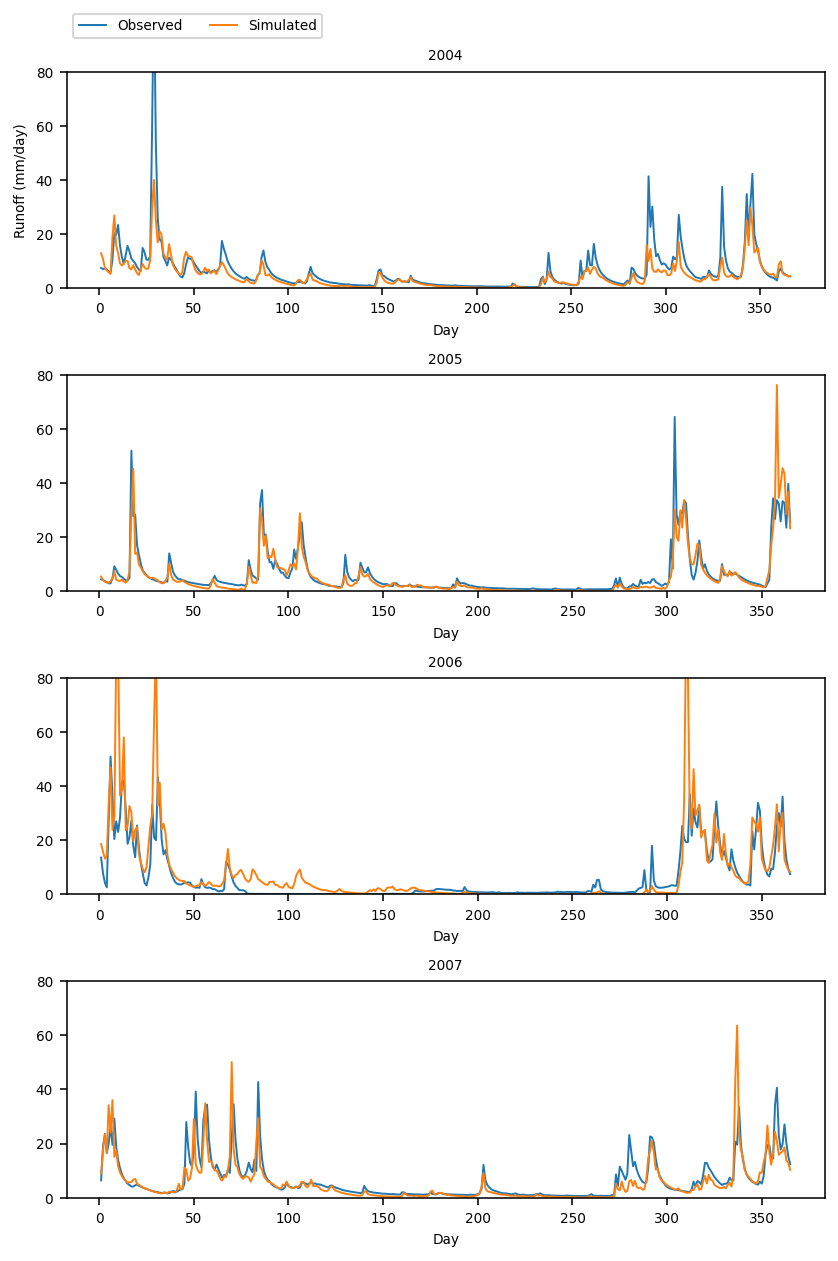

In [5]:
# Observed vs. simulated runoff
years = runoff_obs_yearly.columns.get_level_values(1)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))
for col, year in enumerate(years):
    runoff_obs_yearly.iloc[:, col].plot(ax=axes[col], label='Observed', linewidth=1)
    runoff_sim_yearly.iloc[:, col].plot(ax=axes[col], label='Simulated', linewidth=1)
    axes[col].set_title(year)
    axes[col].set_ylim([0, 80])
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.3), fancybox=True, ncol=2)
axes[0].set_ylabel('Runoff (mm/day)')
plt.tight_layout()

In [6]:
# Nash-Sutcliffe Efficiency (NSE) 

def NSE_individ(s, o):
    # s,o = filter_nan(s,o)
#     return 1 - (o - s)**2/(o - np.mean(o))**2
    mean_obs = np.mean(o)
    numerator = (o - s)**2
    denominator = (o - mean_obs)**2
    return 1 - (numerator/denominator)

years = runoff_obs_yearly.columns.get_level_values(1)
runoff_nse = pd.DataFrame(columns=years)
for i, year in enumerate(years):
    runoff_nse.iloc[:, i] = NSE_individ(runoff_sim_yearly.iloc[:, i], runoff_obs_yearly.iloc[:, i])

def NSE_rel_individ(s, o):
    # s,o = filter_nan(s,o)
    return 1 - ((s-o)/o)**2/((o-np.mean(o))/np.mean(o))**2

years = runoff_obs_yearly.columns.get_level_values(1)
runoff_nse_rel = pd.DataFrame(columns=years)
for i, year in enumerate(years):
    runoff_nse_rel.iloc[:, i] = NSE_rel_individ(runoff_sim_yearly.iloc[:, i], runoff_obs_yearly.iloc[:, i])


## Cumulative NSE

In [7]:
def NSE(s, o):
    obs_mean = np.nanmean(o)
    numerator = np.nansum((o - s)**2)
    denominator = np.nansum((o - obs_mean)**2)
    return 1 - numerator/denominator

In [8]:
# Actual NSE values for the entire years
display('NS (2004): ', NSE(runoff_sim_yearly.iloc[:, 0], runoff_obs_yearly.iloc[:, 0]))
display('NS (2005): ', NSE(runoff_sim_yearly.iloc[:, 1], runoff_obs_yearly.iloc[:, 1]))
display('NS (2006): ', NSE(runoff_sim_yearly.iloc[:, 2], runoff_obs_yearly.iloc[:, 2]))
display('NS (2007): ', NSE(runoff_sim_yearly.iloc[:, 3], runoff_obs_yearly.iloc[:, 3]))

'NS (2004): '

0.6005535538604774

'NS (2005): '

0.7509217791510732

'NS (2006): '

0.054723354364196175

'NS (2007): '

0.579676568310854

#### Calculate NSE each day using runoff values from the preceding days of the year so far

In [9]:
years = runoff_obs_yearly.columns.get_level_values(1)
all_nses = []
for i, year in enumerate(years):
    obs = []
    sims = []
    yearly_nses = []
    for j in range(runoff_sim_yearly.shape[0]):
        obs.append(runoff_obs_yearly.iloc[j, i])
        sims.append(runoff_sim_yearly.iloc[j, i])
        arr = np.column_stack([sims, obs])
        result = NSE(arr[:, 0], arr[:, 1])
        if np.isneginf(result):
            result = 0
        yearly_nses.append(result)
    all_nses.append(yearly_nses)

for x in all_nses:
    if len(x) == 365:
        x.append(0)
df = pd.DataFrame(all_nses)
cum_nses = df.transpose()
cum_nses.columns = years
cum_nses.head()

C:\Users\ipdavies\AppData\Local\Continuum\anaconda3\envs\tnc_velma\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


year,2004,2005,2006,2007
0,0.000000,0.000000,0.000000,0.000000
1,-518.215517,-26.284477,-4.380135,0.892003
2,-518.972265,-4.001358,-2.775024,0.946225
3,-291.075995,-1.084957,-3.249730,0.946194
4,-44.783340,0.110329,0.048978,-0.257139


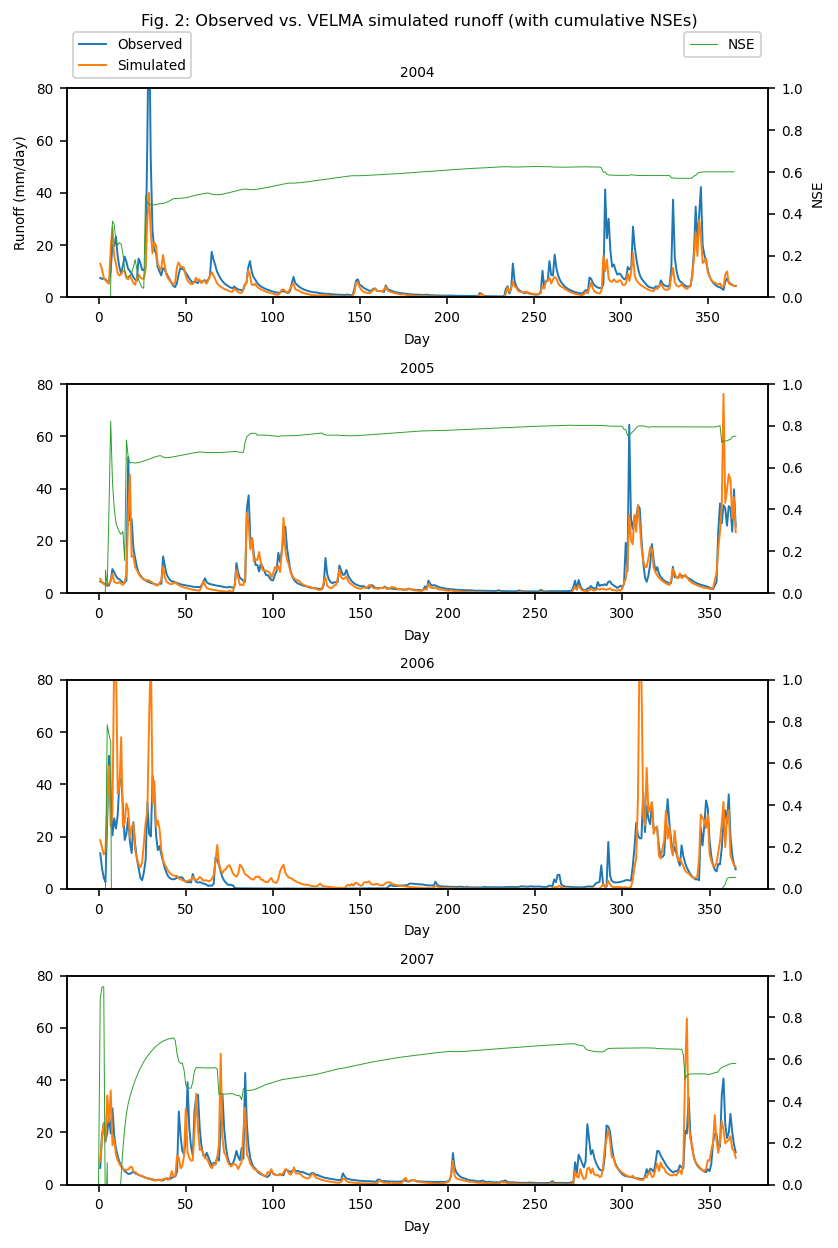

In [10]:
# Observed vs. simulated runoff
years = runoff_obs_yearly.columns.get_level_values(1)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))

for col, year in enumerate(years):
    ax2 = axes[col].twinx()
    cum_nses.iloc[:, col].plot(ax=ax2, label='NSE', linewidth=0.5, color='tab:green')
    if col == 0:
        ax2.set_ylabel('NSE')
        ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.3), fancybox=True, ncol=1)
    runoff_obs_yearly.iloc[:, col].plot(ax=axes[col], label='Observed', linewidth=1)
    runoff_sim_yearly.iloc[:, col].plot(ax=axes[col], label='Simulated', linewidth=1)
    ax2.invert_yaxis()
    axes[col].set_ylim([0, 80])
    ax2.set_ylim([0, 1])
    axes[col].set_title(year)
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.3))
axes[0].set_ylabel('Runoff (mm/day)')
fig.suptitle('Fig. 2: Observed vs. VELMA simulated runoff (with cumulative NSEs)')
plt.tight_layout()

## Cumulative NSE after removing extreme values

#### Remove less reliable values based on quality flags
"Exceeded rating table (>2x)" (160), "Below rating table (<1/2x)" (161), "Estimated - unreliable" (179).

In [11]:
runoff_sim = velma_results['Runoff_All(mm/day)_Delineated_Average']
df = pd.concat([runoff_sim, runoff_obs, quality], axis=1)
# df_edited = df.drop(df[(df['Quality'] == 50) | (df['Quality'] == 160) | (df['Quality'] == 161) | (df['Quality'] == 179)].index)
df_edited = df.drop(df[(df['Quality'] == 160) | (df['Quality'] == 161) | (df['Quality'] == 179)].index)
df_edited = df.drop(df[(df['Quality'] == 160) | (df['Quality'] == 161) | (df['Quality'] == 179) | (df['Quality'] == 254)].index)

In [12]:
# 2003-2007 runoff
sim_yearly = pd.pivot_table(df_edited[['Runoff_All(mm/day)_Delineated_Average', 'doy', 'year']], 
                            index=['doy'], 
                            columns=['year'], 
                            values=['Runoff_All(mm/day)_Delineated_Average'])

obs_yearly = pd.pivot_table(df_edited[['runoff_obs', 'doy', 'year']], 
                            index=['doy'], 
                            columns=['year'], 
                            values=['runoff_obs'])

display('NSE after removing extreme flagged values')
display('NS (2004): ', NSE(sim_yearly.iloc[:, 0], obs_yearly.iloc[:, 0]))
display('NS (2005): ', NSE(sim_yearly.iloc[:, 1], obs_yearly.iloc[:, 1]))
display('NS (2006): ', NSE(sim_yearly.iloc[:, 2], obs_yearly.iloc[:, 2]))
display('NS (2007): ', NSE(sim_yearly.iloc[:, 3], obs_yearly.iloc[:, 3]))

df_edited_04_07 = df_edited[(df_edited.index >= pd.to_datetime('2004-01-01'))]
display('NS (2004-2007): ', NSE(df_edited_04_07['Runoff_All(mm/day)_Delineated_Average'], df_edited_04_07['runoff_obs']))
display('RMSE (2004-2007): ', np.sqrt(mean_squared_error(df_edited_04_07['Runoff_All(mm/day)_Delineated_Average'], df_edited_04_07['runoff_obs'])))
display('MAE (2004-2007): ', mean_absolute_error(df_edited_04_07['Runoff_All(mm/day)_Delineated_Average'], df_edited_04_07['runoff_obs']))


'NSE after removing extreme flagged values'

'NS (2004): '

0.6606872992039245

'NS (2005): '

0.8046441136760274

'NS (2006): '

0.8233690971485395

'NS (2007): '

0.7219685776786358

'NS (2004-2007): '

0.7804890506708528

'RMSE (2004-2007): '

3.3870441646509186

'MAE (2004-2007): '

1.7899139932697459

#### Calculate NSE each day using runoff values from the preceding days of the year so far

In [13]:
years = obs_yearly.columns.get_level_values(1)
all_nses = []
for i, year in enumerate(years):
    obs = []
    sims = []
    yearly_nses = []
    for j in range(obs_yearly.shape[0]):
        obs.append(obs_yearly.iloc[j, i])
        sims.append(sim_yearly.iloc[j, i])
        arr = np.column_stack([sims, obs])
        result = NSE(arr[:, 0], arr[:, 1])
        if np.isneginf(result):
            result = 0
        yearly_nses.append(result)
    all_nses.append(yearly_nses)

for x in all_nses:
    if len(x) == 365:
        x.append(0)
df = pd.DataFrame(all_nses)
edited_cum_nses = df.transpose()
edited_cum_nses.columns = years
edited_cum_nses.tail()

C:\Users\ipdavies\AppData\Local\Continuum\anaconda3\envs\tnc_velma\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


year,2004,2005,2006,2007
361,0.660688,0.776317,0.823335,0.720251
362,0.660691,0.780557,0.823373,0.720865
363,0.660685,0.799005,0.823403,0.721692
364,0.660684,0.804644,0.823369,0.721969
365,0.660687,0.804644,0.823369,0.721969


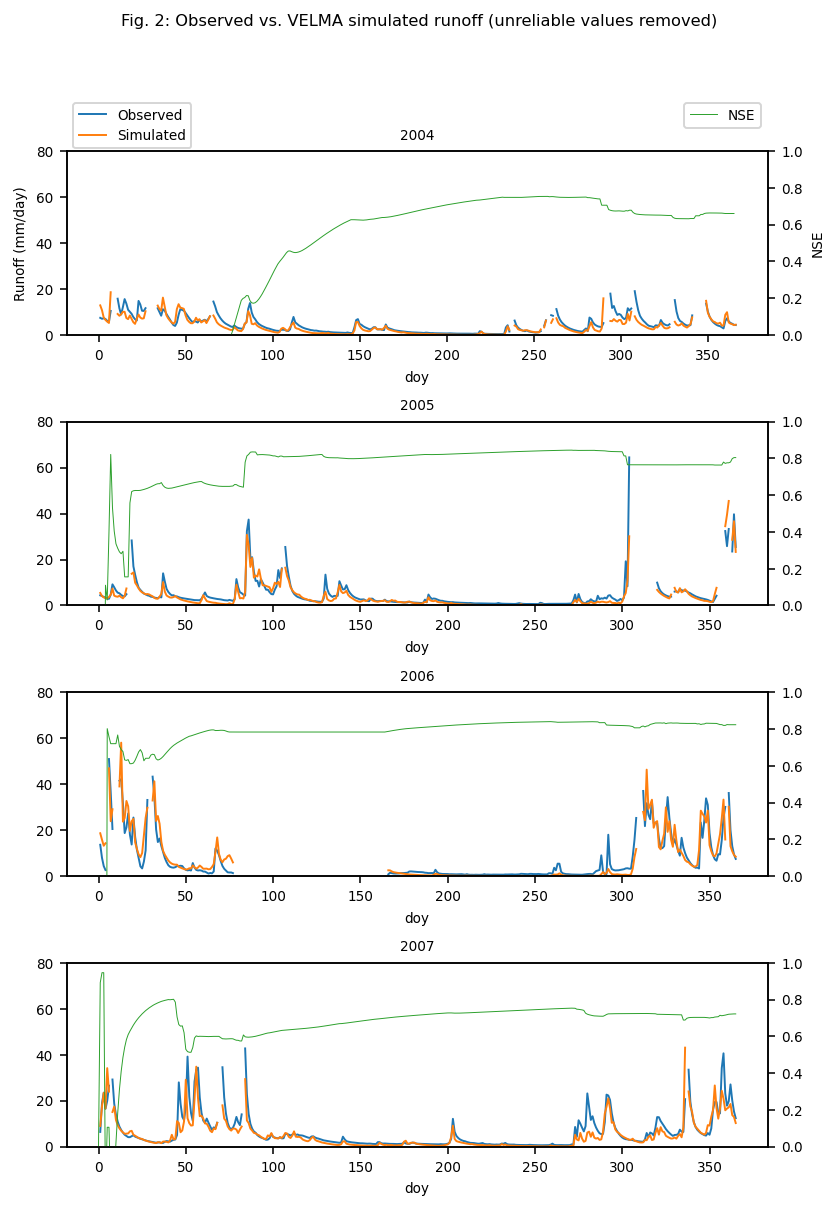

In [14]:
years = runoff_obs_yearly.columns.get_level_values(1)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))

for col, year in enumerate(years):
    ax2 = axes[col].twinx()
    edited_cum_nses.iloc[:, col].plot(ax=ax2, label='NSE', linewidth=0.5, color='tab:green')
    if col == 0:
        ax2.set_ylabel('NSE')
        ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.3), fancybox=True, ncol=1)
    obs_yearly.iloc[:, col].plot(ax=axes[col], label='Observed', linewidth=1)
    sim_yearly.iloc[:, col].plot(ax=axes[col], label='Simulated', linewidth=1)
    ax2.invert_yaxis()
    axes[col].set_ylim([0, 80])
    ax2.set_ylim([0, 1])
    axes[col].set_title(year)
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.3))
axes[0].set_ylabel('Runoff (mm/day)')
fig.suptitle('Fig. 2: Observed vs. VELMA simulated runoff (unreliable values removed)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Cumulative relative NSE

In [15]:
def rel_NSE(s, o):
    obs_mean = np.nanmean(o)
    numerator = np.nansum(((o - s)**2) / o)
    denominator = np.nansum(((o - obs_mean)**2) / o )
    return 1 - numerator/denominator

In [16]:
years = obs_yearly.columns.get_level_values(1)
all_nses = []
for i, year in enumerate(years):
    obs = []
    sims = []
    yearly_nses = []
    for j in range(obs_yearly.shape[0]):
        obs.append(obs_yearly.iloc[j, i])
        sims.append(sim_yearly.iloc[j, i])
        arr = np.column_stack([sims, obs])
        result = rel_NSE(arr[:, 0], arr[:, 1])
        if np.isneginf(result):
            result = 0
        yearly_nses.append(result)
    all_nses.append(yearly_nses)

for x in all_nses:
    if len(x) == 365:
        x.append(0)
df = pd.DataFrame(all_nses)
edited_cum_rel_nses = df.transpose()
edited_cum_rel_nses.columns = years
edited_cum_rel_nses.tail()

C:\Users\ipdavies\AppData\Local\Continuum\anaconda3\envs\tnc_velma\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


year,2004,2005,2006,2007
361,0.905108,0.893028,0.914585,0.923533
362,0.905172,0.895942,0.915080,0.924172
363,0.905193,0.901955,0.915282,0.924778
364,0.905162,0.905177,0.915285,0.925145
365,0.905119,0.905177,0.915285,0.925145


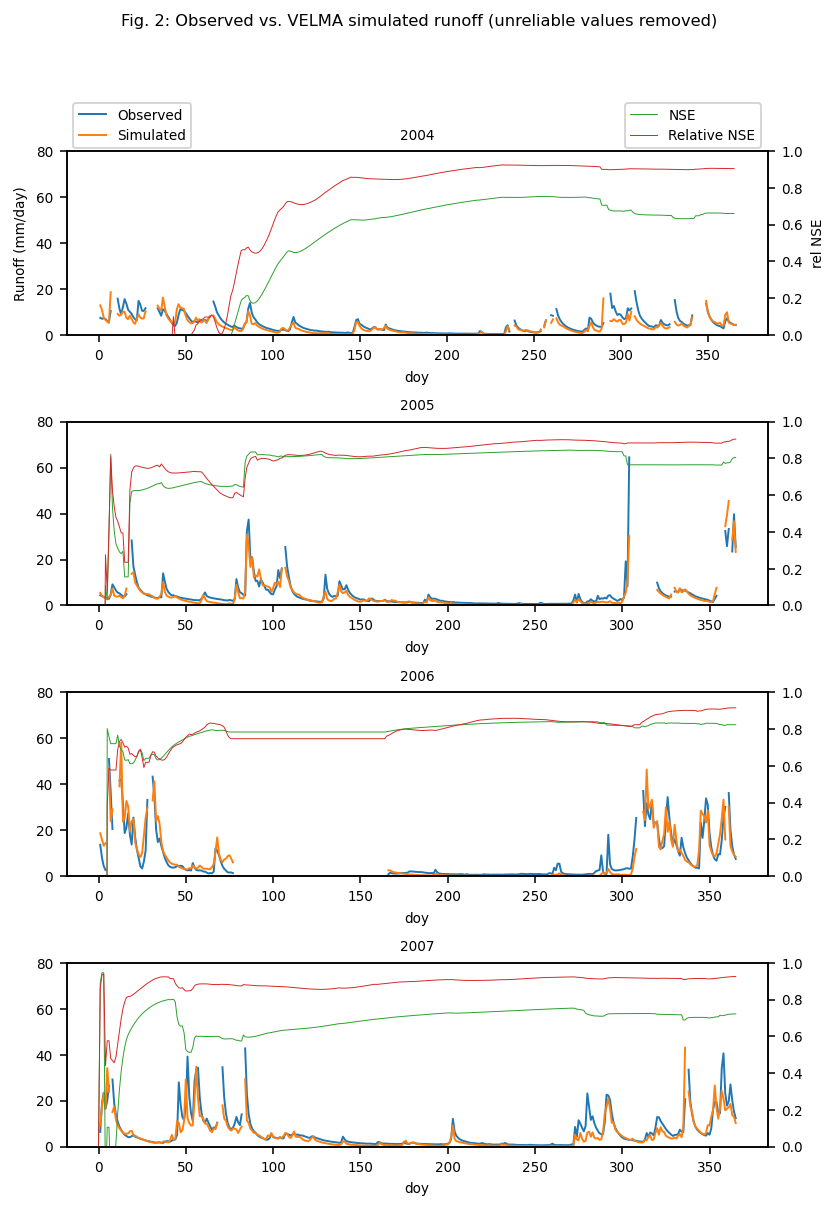

In [17]:
years = runoff_obs_yearly.columns.get_level_values(1)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))

for col, year in enumerate(years):
    ax2 = axes[col].twinx()
    edited_cum_nses.iloc[:, col].plot(ax=ax2, label='NSE', linewidth=0.5, color='tab:green')
    edited_cum_rel_nses.iloc[:, col].plot(ax=ax2, label='Relative NSE', linewidth=0.5, color='tab:red')
    if col == 0:
        ax2.set_ylabel('rel NSE')
        ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.3), fancybox=True, ncol=1)
    obs_yearly.iloc[:, col].plot(ax=axes[col], label='Observed', linewidth=1)
    sim_yearly.iloc[:, col].plot(ax=axes[col], label='Simulated', linewidth=1)
    ax2.invert_yaxis()
    axes[col].set_ylim([0, 80])
    ax2.set_ylim([0, 1])
    axes[col].set_title(year)
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.3))
axes[0].set_ylabel('Runoff (mm/day)')
fig.suptitle('Fig. 2: Observed vs. VELMA simulated runoff (unreliable values removed)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

#### Relative NSE always outperforms NSE, and doesn't seem sensitive to any of the errors which suggests it is not a very informative metric

## Cumulative log NSE

In [18]:
def log_NSE(s, o):
    s = np.log(s)
    o = np.log(o)
    obs_mean = np.nanmean(o)
    numerator = np.nansum(((o - s)**2))
    denominator = np.nansum(((o - obs_mean)**2))
    return 1 - numerator/denominator


In [19]:
years = obs_yearly.columns.get_level_values(1)
all_nses = []
for i, year in enumerate(years):
    obs = []
    sims = []
    yearly_nses = []
    for j in range(obs_yearly.shape[0]):
        obs.append(obs_yearly.iloc[j, i])
        sims.append(sim_yearly.iloc[j, i])
        arr = np.column_stack([sims, obs])
        result = log_NSE(arr[:, 0], arr[:, 1])
        if np.isneginf(result):
            result = 0
        yearly_nses.append(result)
    all_nses.append(yearly_nses)

for x in all_nses:
    if len(x) == 365:
        x.append(0)
df = pd.DataFrame(all_nses)
edited_cum_log_nses = df.transpose()
edited_cum_log_nses.columns = years
edited_cum_log_nses.tail()

C:\Users\ipdavies\AppData\Local\Continuum\anaconda3\envs\tnc_velma\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


year,2004,2005,2006,2007
361,0.574134,0.136381,-0.276456,0.645181
362,0.574484,0.150075,-0.270571,0.647409
363,0.574745,0.170594,-0.266986,0.649141
364,0.574906,0.184121,-0.264778,0.650358
365,0.575043,0.184121,-0.264778,0.650358


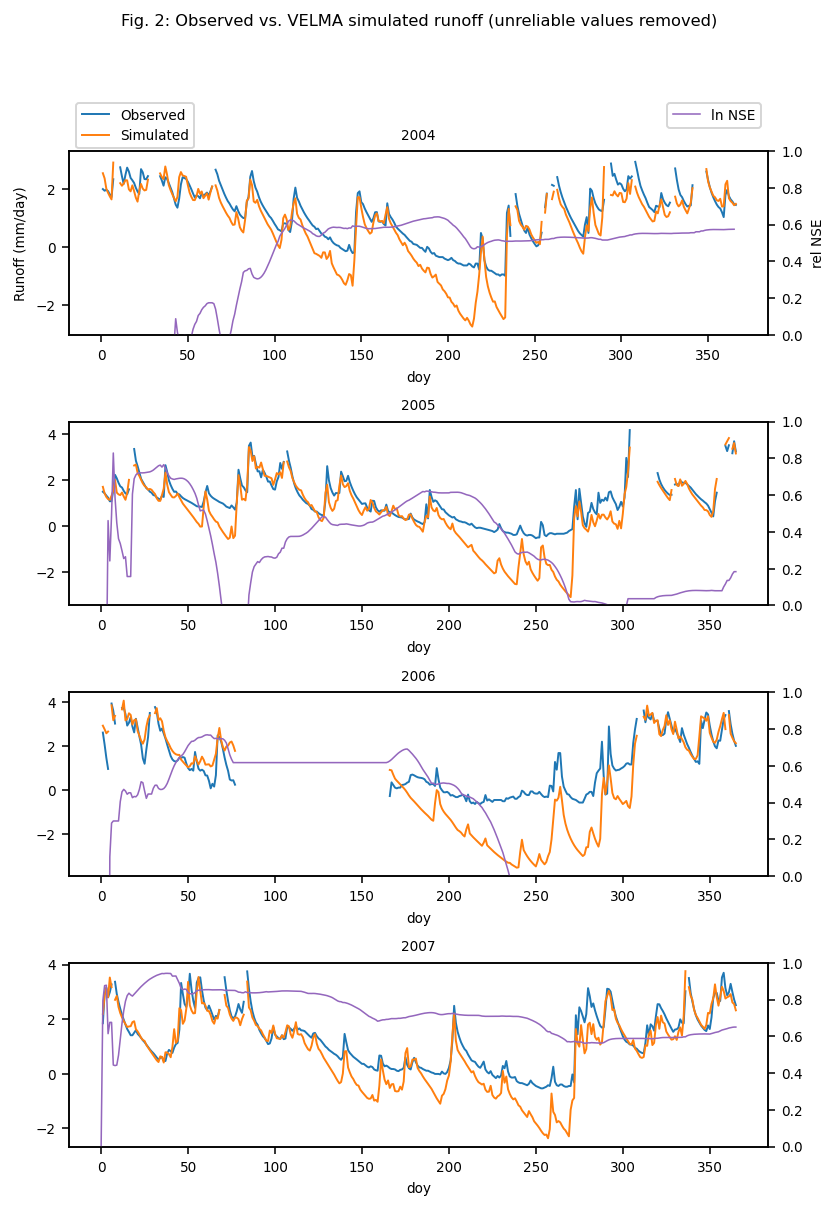

In [20]:
years = runoff_obs_yearly.columns.get_level_values(1)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))

for col, year in enumerate(years):
    ax2 = axes[col].twinx()
#     edited_cum_nses.iloc[:, col].plot(ax=ax2, label='NSE', linewidth=0.5, color='tab:green')
#     edited_cum_rel_nses.iloc[:, col].plot(ax=ax2, label='Relative NSE', linewidth=0.5, color='tab:red')
    edited_cum_log_nses.iloc[:, col].plot(ax=ax2, label='ln NSE', linewidth=0.8, color='tab:purple')
    if col == 0:
        ax2.set_ylabel('rel NSE')
        ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.3), fancybox=True, ncol=1)
    np.log(obs_yearly.iloc[:, col]).plot(ax=axes[col], label='Observed', linewidth=1)
    np.log(sim_yearly.iloc[:, col]).plot(ax=axes[col], label='Simulated', linewidth=1)
    ax2.invert_yaxis()
#     axes[col].set_ylim([0, 80])
#     axes[col].set_yscale('log')
    ax2.set_ylim([0, 1])
    axes[col].set_title(year)
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.3))
axes[0].set_ylabel('Runoff (mm/day)')
fig.suptitle('Fig. 2: Observed vs. VELMA simulated runoff (unreliable values removed)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

#### Log NSE too sensitive to low flows, very erratic

## Cumulative modified NSE
Modified using absolute error terms instead of squared

In [21]:
def abs_NSE(s, o):
    obs_mean = np.nanmean(o)
    numerator = np.nansum((np.absolute(o - s)))
    denominator = np.nansum((np.absolute(o - obs_mean)))
    return 1 - numerator/denominator


In [22]:
years = obs_yearly.columns.get_level_values(1)
all_nses = []
for i, year in enumerate(years):
    obs = []
    sims = []
    yearly_nses = []
    for j in range(obs_yearly.shape[0]):
        obs.append(obs_yearly.iloc[j, i])
        sims.append(sim_yearly.iloc[j, i])
        arr = np.column_stack([sims, obs])
        result = log_NSE(arr[:, 0], arr[:, 1])
        if np.isneginf(result):
            result = 0
        yearly_nses.append(result)
    all_nses.append(yearly_nses)

for x in all_nses:
    if len(x) == 365:
        x.append(0)
df = pd.DataFrame(all_nses)
edited_cum_abs_nses = df.transpose()
edited_cum_abs_nses.columns = years
edited_cum_abs_nses.tail()

C:\Users\ipdavies\AppData\Local\Continuum\anaconda3\envs\tnc_velma\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


year,2004,2005,2006,2007
361,0.574134,0.136381,-0.276456,0.645181
362,0.574484,0.150075,-0.270571,0.647409
363,0.574745,0.170594,-0.266986,0.649141
364,0.574906,0.184121,-0.264778,0.650358
365,0.575043,0.184121,-0.264778,0.650358


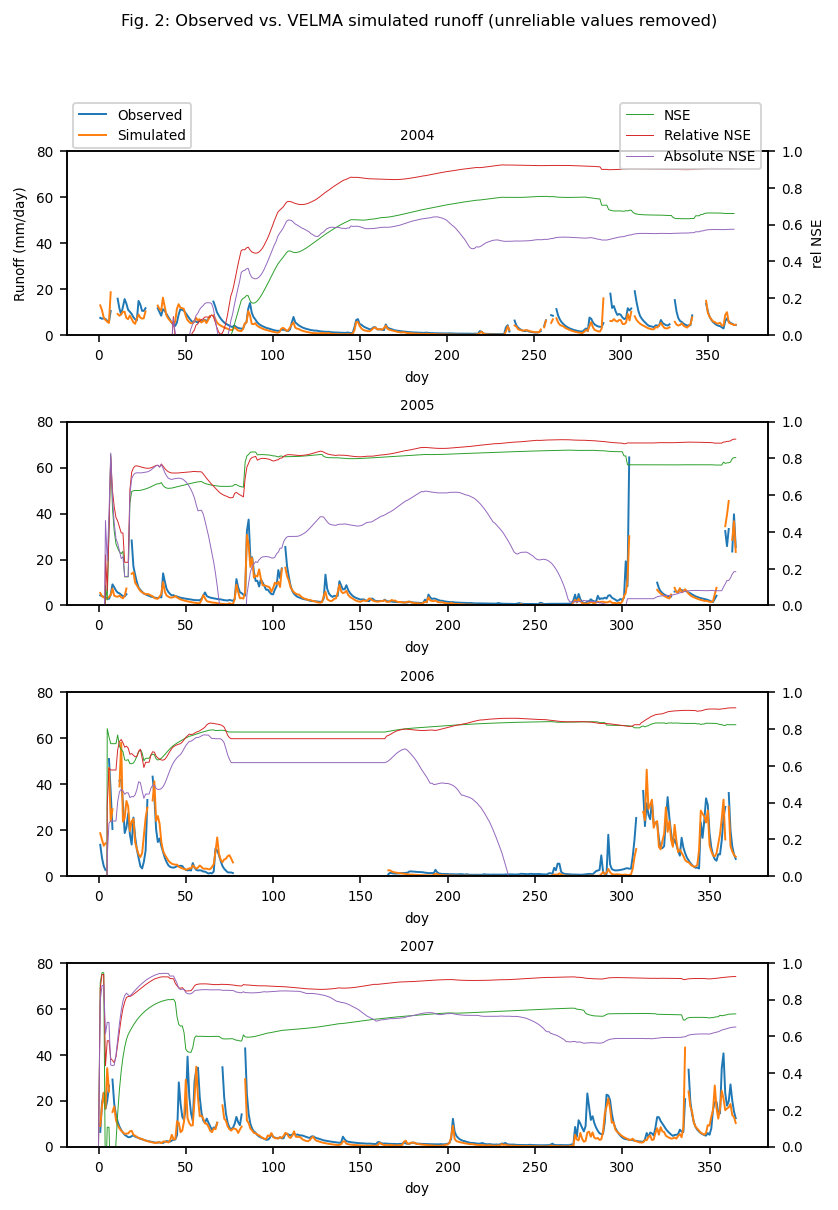

In [23]:
years = runoff_obs_yearly.columns.get_level_values(1)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))

for col, year in enumerate(years):
    ax2 = axes[col].twinx()
    edited_cum_nses.iloc[:, col].plot(ax=ax2, label='NSE', linewidth=0.5, color='tab:green')
    edited_cum_rel_nses.iloc[:, col].plot(ax=ax2, label='Relative NSE', linewidth=0.5, color='tab:red')
    edited_cum_abs_nses.iloc[:, col].plot(ax=ax2, label='Absolute NSE', linewidth=0.5, color='tab:purple')
    if col == 0:
        ax2.set_ylabel('rel NSE')
        ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.3), fancybox=True, ncol=1)
    obs_yearly.iloc[:, col].plot(ax=axes[col], label='Observed', linewidth=1)
    sim_yearly.iloc[:, col].plot(ax=axes[col], label='Simulated', linewidth=1)
    ax2.invert_yaxis()
    axes[col].set_ylim([0, 80])
    ax2.set_ylim([0, 1])
    axes[col].set_title(year)
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.3))
axes[0].set_ylabel('Runoff (mm/day)')
fig.suptitle('Fig. 2: Observed vs. VELMA simulated runoff (unreliable values removed)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])